## Import Relevant Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

In [7]:
old_folder_name = 'OCT2017 '
new_folder_name = 'OCT2017'
os.rename(old_folder_name, new_folder_name)

## Apply CNN Model with 3 layers without Image Augmentation

In [ ]:
# Generate batches of tensor image data with real-time data augmentation
datagen = ImageDataGenerator(validation_split=0.2)

train_generator = datagen.flow_from_directory(
    "OCT2017/train",
    target_size = (224, 224),
    batch_size=128,
    class_mode="categorical",
    subset = "training"
)

validation_generator = datagen.flow_from_directory(
    "OCT2017/train",
    target_size = (224, 224),
    batch_size=128,
    class_mode = "categorical",
    subset = "validation"
)

Found 66788 images belonging to 4 classes.
Found 16696 images belonging to 4 classes.


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Reference: https://keras.io/api/layers/convolution_layers/convolution2d/
# Reference: https://keras.io/api/layers/normalization_layers/batch_normalization/
# Reference: https://keras.io/api/layers/pooling_layers/max_pooling2d/
# Reference: https://keras.io/api/layers/regularization_layers/dropout/
# Reference: https://keras.io/api/layers/pooling_layers/global_average_pooling2d/
# Reference: https://keras.io/api/layers/core_layers/dense/

input_shape = (224, 224, 3)

Input_Layer = Input(shape=(input_shape))

# Convolutional layer
first_conv2D = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(Input_Layer)
# Batch Normalization
first_batch_normalization = BatchNormalization()(first_conv2D)

# Convolutional layer
second_conv2D = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(first_batch_normalization)
# Batch Normalization
second_batch_normalization = BatchNormalization()(second_conv2D)

# MaxPool Layer
maxpool = MaxPooling2D(pool_size=(2,2))(second_batch_normalization)
# Dropout Layer
dropout = Dropout(rate=0.2)(maxpool)

# Convolutional layer
third_conv2D = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(dropout)
third_batch_normalization = BatchNormalization()(third_conv2D)

# GlovalAveragePooling Layer
global_average_pool = GlobalAveragePooling2D()(third_batch_normalization)

# Dense Layer
output_layer = Dense(4, activation="softmax")(global_average_pool)

model1 = Model(inputs = Input_Layer, outputs=output_layer)

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_7 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 batch_normalization_8 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0     

In [ ]:
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1)
filepath="model1_without_augmentation_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')

# Callbacks
optimizer = tf.keras.optimizers.Adam()
model1.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])

# Creating a list with all the callbacks we want
callback_list = [earlystop, checkpoint]

train_samples = 66788
validation_samples = 16696
batch_size = 128
model1.fit(train_generator, validation_data= validation_generator, steps_per_epoch=train_samples//batch_size, callbacks=callback_list, epochs=50)

Epoch 1/50
521/521 [==============================] - ETA: 0s - loss: 0.7900 - accuracy: 0.7058
Epoch 1: val_accuracy improved from -inf to 0.70053, saving model to model1_without_augmentation_save/weights-01-0.7005.hdf5
521/521 [==============================] - 675s 1s/step - loss: 0.7900 - accuracy: 0.7058 - val_loss: 0.8375 - val_accuracy: 0.7005
Epoch 2/50
521/521 [==============================] - ETA: 0s - loss: 0.5570 - accuracy: 0.7970
Epoch 2: val_accuracy improved from 0.70053 to 0.70688, saving model to model1_without_augmentation_save/weights-02-0.7069.hdf5
521/521 [==============================] - 642s 1s/step - loss: 0.5570 - accuracy: 0.7970 - val_loss: 0.7454 - val_accuracy: 0.7069
Epoch 3/50
521/521 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.8489
Epoch 3: val_accuracy improved from 0.70688 to 0.74784, saving model to model1_without_augmentation_save/weights-03-0.7478.hdf5
521/521 [==============================] - 637s 1s/step - loss: 0.4

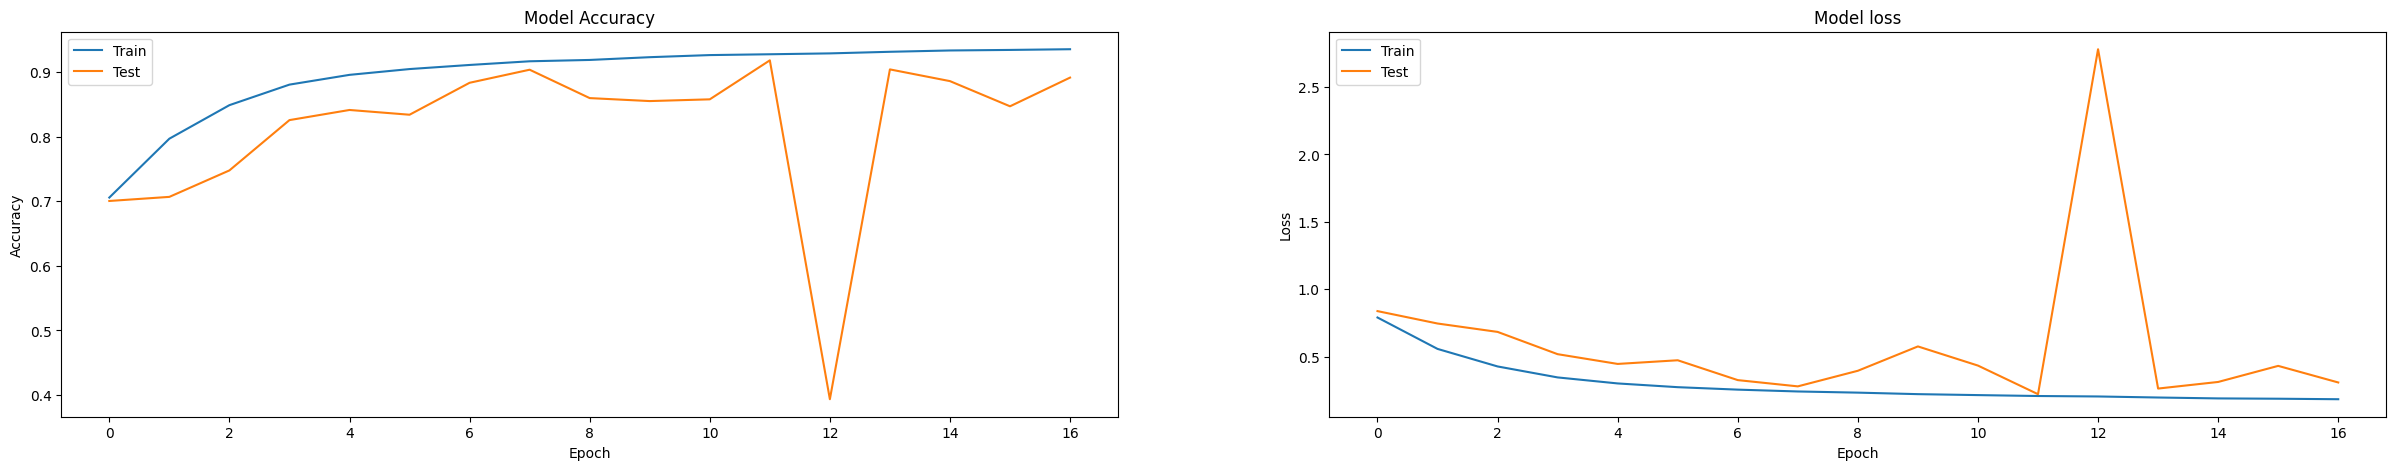

In [ ]:
# Plotting training & Validation accuracy values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(model1.history.history['accuracy'])
plt.plot(model1.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel("Accuracy")
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(model1.history.history['loss'])
plt.plot(model1.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
# Accuracy on test dataset

test_generator = datagen.flow_from_directory(
    "OCT2017/test",
    target_size = (224, 224),
    batch_size = 128,
    class_mode="categorical",
    shuffle=False
)
test_samples = 968
batch_size = 128

result = model1.evaluate(test_generator, steps=test_samples//batch_size+1, verbose=1)
print(f"Accuracy on Test Dataset: {result[1]*100}, Loss on Test Dataset: {result[0]}")

Found 968 images belonging to 4 classes.
8/8 [==============================] - 7s 874ms/step - loss: 0.1776 - accuracy: 0.9277
Accuracy on Test Dataset: 92.76859760284424, Loss on Test Dataset: 0.17764516174793243


8/8 [==============================] - 5s 573ms/step


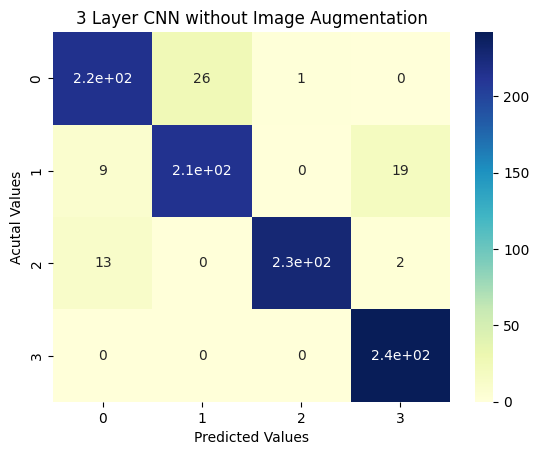

In [ ]:
# Confusion Matrix
y_pred = model1.predict(test_generator, test_samples//batch_size+1)
predicted_values = np.argmax(y_pred, axis=1)

confusion = confusion_matrix(test_generator.classes,predicted_values)
plt.title("3 Layer CNN without Image Augmentation")
sns.heatmap(confusion, annot=True, cmap="YlGnBu")
plt.xlabel('Predicted Values')
plt.ylabel('Acutal Values')
plt.show()

## Observations:
- We are getting an accuracy of 0.92 on the test dataset using simple 3 Layers CNN model without Image Augmentation.

# Apply 3 Layers CNN Model with Image Augmentation

In [8]:
# generate batches of tensor image data with real-time data augmentation

datagen = ImageDataGenerator(rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

train_generator = datagen.flow_from_directory(
    "OCT2017/train",
    target_size = (224,224),
    batch_size = 128,
    class_mode = 'categorical',
    subset="training"
)

validation_generator = datagen.flow_from_directory(
    "OCT2017/train",
    target_size=(224, 224),
    batch_size = 128,
    class_mode = "categorical",
    subset = "validation"
)

Found 66788 images belonging to 4 classes.
Found 16696 images belonging to 4 classes.


In [9]:
tf.keras.backend.clear_session()

In [10]:
input_shape = (224,224,3)

# Input Layer
Input_Layer = Input(shape=(input_shape))

# Convolutional Layer
First_Conv2D = Conv2D(32, kernel_size = (3, 3), activation="relu",padding = 'same')(Input_Layer)
# Batch Normalization
First_BatchNormalization = BatchNormalization()(First_Conv2D)

# Convolutional Layer
Second_Conv2D = Conv2D(64, kernel_size = (3, 3), activation="relu",padding = 'same')(First_BatchNormalization)
# Batch Normalization
Second_BatchNormalization = BatchNormalization()(Second_Conv2D)

# MaxPool Layer
maxpool = MaxPooling2D(pool_size=(2,2))(Second_BatchNormalization)
# Dropout Layer
dropout = Dropout(rate=0.2)(maxpool)

# Convolutional Layer
Third_Conv2D = Conv2D(64, kernel_size = (3, 3), activation="relu",padding = 'same')(dropout)
# Batch Normalization
Third_BatchNormalization = BatchNormalization()(Third_Conv2D)

# GlobalAveragePooling Layer
global_average_pool = GlobalAveragePooling2D()(Third_BatchNormalization)

# Dense Layer
Output_Layer = Dense(4, activation="softmax")(global_average_pool)

# Creating a model
model2 = Model(inputs=Input_Layer,outputs=Output_Layer)

In [ ]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0     

In [11]:
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1)

filepath = "model2_with_augmentation_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# callbacks
optimizer = tf.keras.optimizers.Adam()
model2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])

# Creating a list with all the callbacks we want
callback_list = [earlystop, checkpoint]

train_samples = 66788
validation_samples = 16696
batch_size = 128
model2.fit(train_generator, validation_data=validation_generator, steps_per_epoch=train_samples//batch_size,
           callbacks=callback_list,
           epochs=50)

Epoch 1/50
521/521 [==============================] - ETA: 0s - loss: 0.8685 - accuracy: 0.6739
Epoch 1: val_accuracy improved from -inf to 0.44568, saving model to model2_with_augmentation_save/weights-01-0.4457.hdf5
521/521 [==============================] - 1471s 3s/step - loss: 0.8685 - accuracy: 0.6739 - val_loss: 5.6457 - val_accuracy: 0.4457
Epoch 2/50
521/521 [==============================] - ETA: 0s - loss: 0.6197 - accuracy: 0.7739
Epoch 2: val_accuracy improved from 0.44568 to 0.74365, saving model to model2_with_augmentation_save/weights-02-0.7437.hdf5
521/521 [==============================] - 1435s 3s/step - loss: 0.6197 - accuracy: 0.7739 - val_loss: 0.6862 - val_accuracy: 0.7437
Epoch 3/50
521/521 [==============================] - ETA: 0s - loss: 0.4887 - accuracy: 0.8274
Epoch 3: val_accuracy improved from 0.74365 to 0.78360, saving model to model2_with_augmentation_save/weights-03-0.7836.hdf5
521/521 [==============================] - 1401s 3s/step - loss: 0.4887 - 

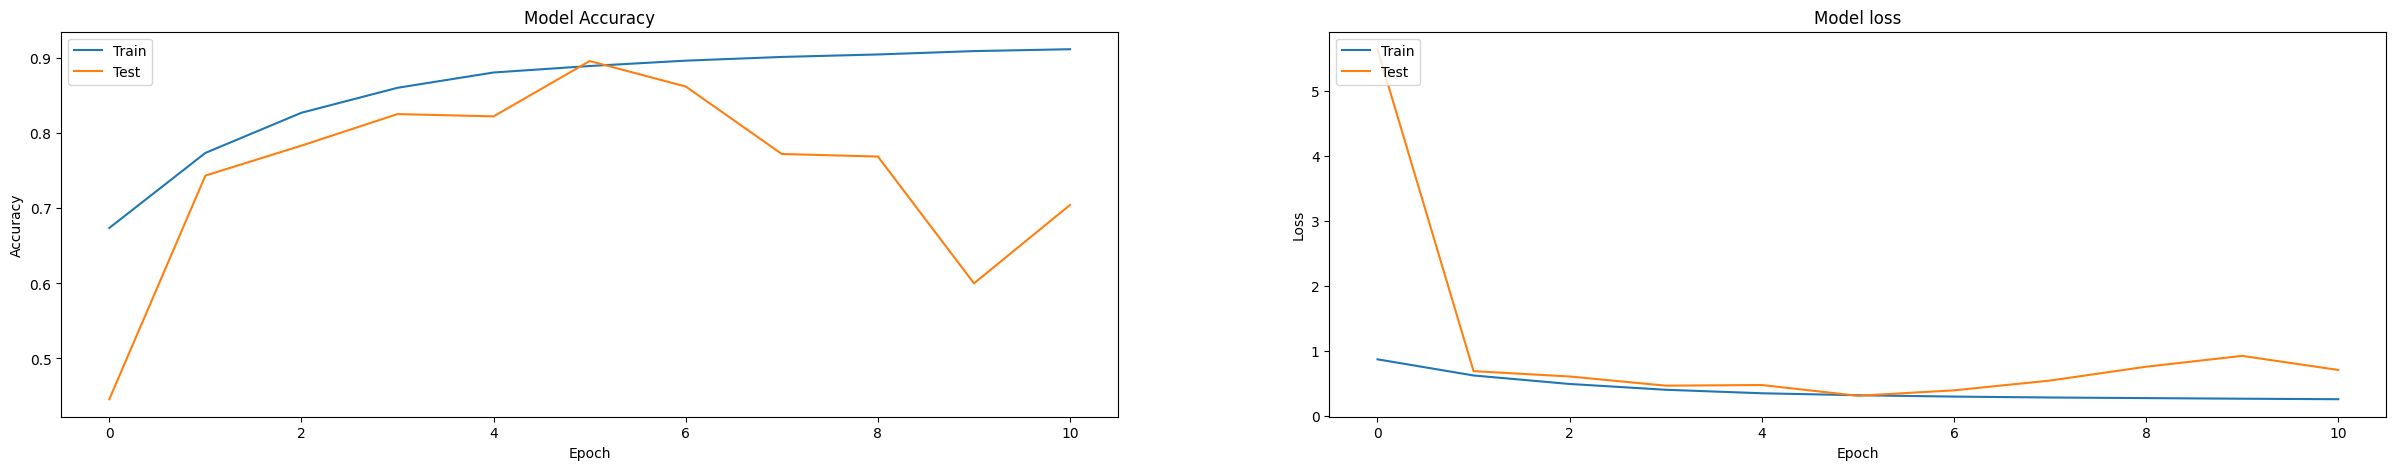

In [12]:
# Plotting training & Validation accuracy values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(model2.history.history['accuracy'])
plt.plot(model2.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel("Accuracy")
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(model2.history.history['loss'])
plt.plot(model2.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [15]:
# Accuracy on test dataset

test_generator = datagen.flow_from_directory(
    "OCT2017/test",
    target_size = (224, 224),
    batch_size = 128,
    class_mode="categorical",
    shuffle=False
)
test_samples = 968
batch_size = 128

result = model2.evaluate(test_generator, steps=test_samples//batch_size+1, verbose=1)
print(f"Accuracy on Test Dataset: {result[1]*100}, Loss on Test Dataset: {result[0]}")

Found 968 images belonging to 4 classes.
8/8 [==============================] - 12s 1s/step - loss: 0.8291 - accuracy: 0.6560
Accuracy on Test Dataset: 65.59917330741882, Loss on Test Dataset: 0.8290548324584961


8/8 [==============================] - 13s 2s/step


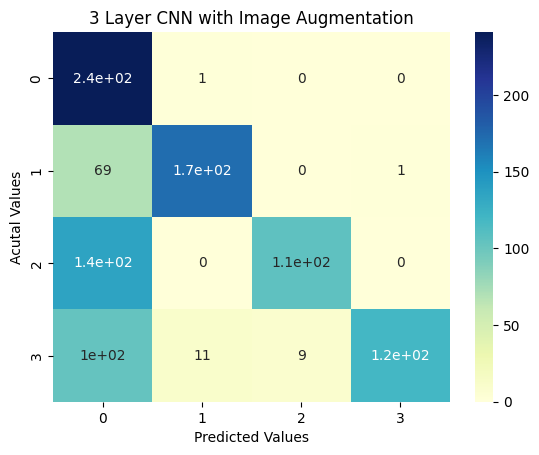

In [14]:
# Confusion Matrix
y_pred = model2.predict(test_generator, test_samples//batch_size+1)
predicted_values = np.argmax(y_pred, axis=1)

confusion = confusion_matrix(test_generator.classes,predicted_values)
plt.title("3 Layer CNN with Image Augmentation")
sns.heatmap(confusion, annot=True, cmap="YlGnBu")
plt.xlabel('Predicted Values')
plt.ylabel('Acutal Values')
plt.show()